<a href="https://colab.research.google.com/github/mehmettirpan/Colab_Machine_Learning/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description: This program uses an artifical recurrent neural network called Long Short Memory (LSTM) to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

#Kütüphaneleri import ediyoruz

In [26]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# Hisse senedi verilerini import edelim
first_df = pd.read_csv('/content/AAPL.csv') # Daha sonra güncelleyeceğim için first eki de ekledim değişkene
# 'Date' sütununu datetime formatına dönüştürelim (zaman aralığı ile filtre yapabilmek için)
first_df['Date'] = pd.to_datetime(first_df['Date'])

# Belirli bir tarih aralığına göre filtreleme yapalım
start_date = '2016-01-01'
end_date = '2023-01-03'

df = first_df[(first_df['Date'] >= start_date) & (first_df['Date'] <= end_date)]
df # hem zamanı kontrol etmek hem de shape kodunu kullanmadan satır ve sütun sayısına bakmak için çıktısını da aldık

,Date,Open,High,Low,Close,Adj Close,Volume
8841,2016-01-04,25.652500,26.342501,25.500000,26.337500,24.009064,270597600
8842,2016-01-05,26.437500,26.462500,25.602501,25.677500,23.407417,223164000
8843,2016-01-06,25.139999,25.592501,24.967501,25.174999,22.949341,273829600
8844,2016-01-07,24.670000,25.032499,24.107500,24.112499,21.980770,324377600
8845,2016-01-08,24.637501,24.777500,24.190001,24.240000,22.096994,283192000
...,...,...,...,...,...,...,...
10599,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800
10600,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504547,85438400
10601,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700
10602,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.378006,77034200


# Eğer ki bu kısımdaki date kısmını sadece tarihlerin yazdığı değerlere çevirmezsek aşağıdaki tabloda ve diğer kullanacağımız kodlarda, grafiklerde tarih yerine satır numaraları yazacaktı bu da doğru sonuçlar elde etmemize ve yanılmamıza neden olur

In [5]:
# 'Date' sütununu datetime formatına dönüştürme
df['Date'] = pd.to_datetime(df['Date'])

# 'Date' sütunundaki tarih verilerini sadece tarih kısmına çevirme
date_list = df['Date'].dt.date.tolist()

<ipython-input-5-387a28daba19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


#Dönüştürdüğümüz date sütununu date kısmına katardık yani yeni bir değişken kullanmak yerine direkt date yazdığımızda doğru sonuçlar almamızı sağladık

In [6]:
df.index = df.pop('Date') # 'Date' sütununu diziye dönüştürdük daha sonra verilerin analizini yaparken bu değerleri indeksleme amacıyla kullanmak için
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.009064,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.407417,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.949341,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.980770,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.096994,283192000
...,...,...,...,...,...,...
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504547,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700


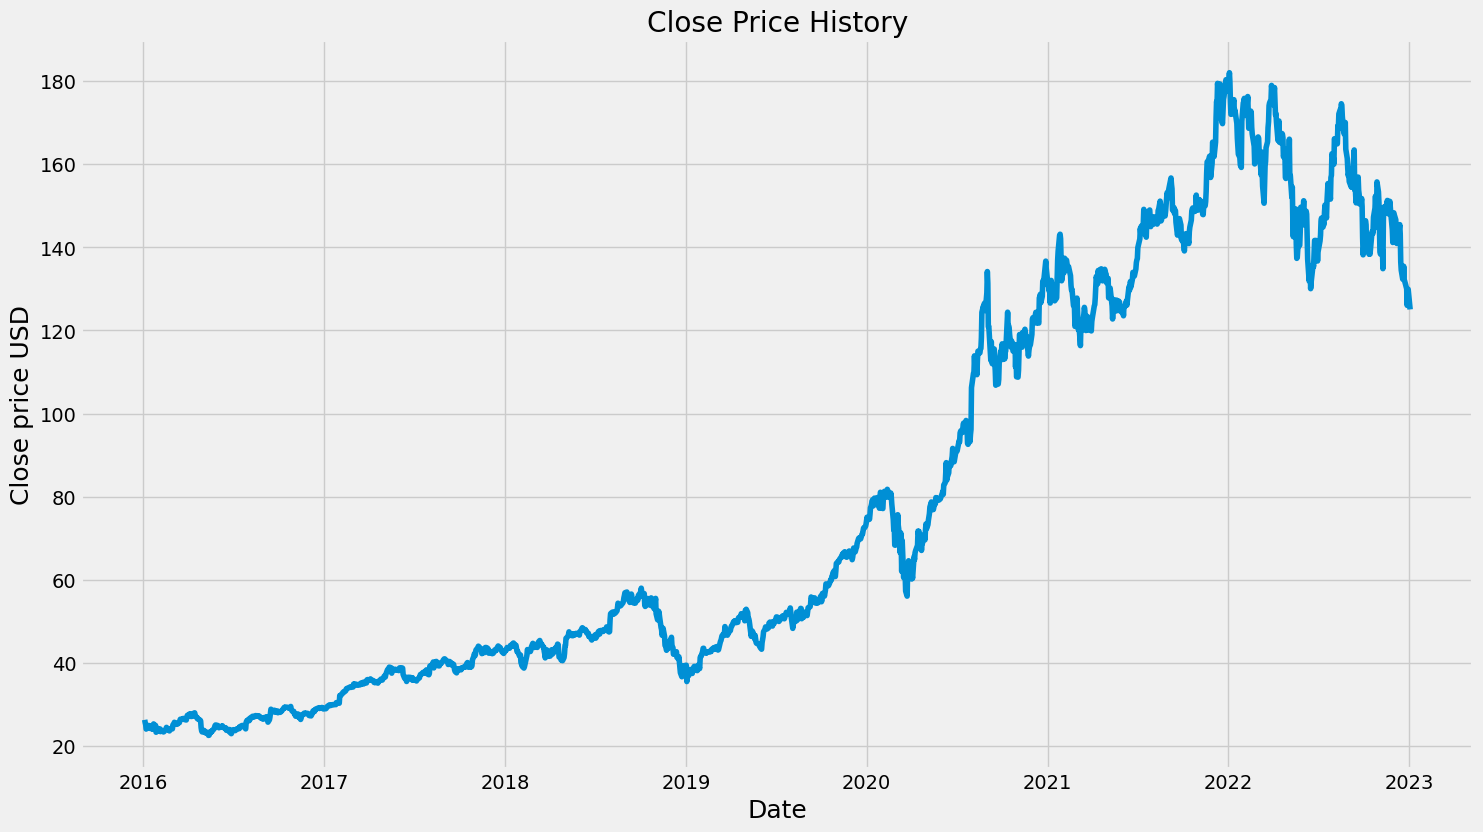

In [24]:
#Vizsualize the closing price history
plt.figure(figsize=(16,9))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD', fontsize=18)
plt.show()

In [8]:
# Create a new dataFrame with only the 'Close Column'
data = df.filter(['Close'])
# Convert the dateframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1411

In [9]:
# Scale the data
scaler = MinMaxScaler( feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02353772],
       [0.01939784],
       [0.01624588],
       ...,
       [0.67131883],
       [0.67332599],
       [0.64284148]])

In [10]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :] #scaled_data[0:training_data_len, :] ifadesi, scaled_data veri kümesinin ilk training_data_len satırını
 #(satır indeksi 0'dan başlayarak) ve tüm sütunlarını (: ifadesi tüm sütunları seçer) içeren bir alt kümesini oluşturur.

#Split the data into x_train and y_train data sets
# Create the training data set
x_train = []
y_train = []

# Append the last 60 scaled values to x_train and the next value to y_train
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
    if i<= 61:
      print(x_train)
      print(y_train)
      print()



[array([0.02353772, 0.01939784, 0.01624588, 0.00958131, 0.01038106,
       0.01284304, 0.01508547, 0.01105536, 0.01439548, 0.01064764,
       0.00991063, 0.01011448, 0.0093461 , 0.01737495, 0.01427005,
       0.01513251, 0.00482986, 0.00588051, 0.01097695, 0.00954995,
       0.00649209, 0.0094245 , 0.00981653, 0.00577074, 0.00732321,
       0.00729183, 0.00616277, 0.00526894, 0.00572369, 0.00987926,
       0.01220011, 0.00928337, 0.00893838, 0.01025561, 0.0068214 ,
       0.00903247, 0.01006744, 0.01030266, 0.00995767, 0.01597931,
       0.0163243 , 0.0175004 , 0.01986829, 0.01808062, 0.01676338,
       0.01690451, 0.01698291, 0.01869219, 0.01909989, 0.02233026,
       0.02450996, 0.02424339, 0.02443156, 0.02441588, 0.02568607,
       0.02476086, 0.02403952, 0.02328683, 0.02719148, 0.03013956])]
[0.02924572756457841]

[array([0.02353772, 0.01939784, 0.01624588, 0.00958131, 0.01038106,
       0.01284304, 0.01508547, 0.01105536, 0.01439548, 0.01064764,
       0.00991063, 0.01011448, 0.00

In [11]:
#Covert the x_train and y_train  to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1351, 60, 1)

In [13]:
from keras.src.engine import sequential
# Build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1351/1351 [==============================] - 46s 32ms/step - loss: 0.0018


In [16]:
#Create the testing data set
#Create a new array containing scaled values from index 1351 to ..

test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [17]:
#Convert the data a numpy array
x_test = np.array(x_test)

In [18]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


11/11 [==============================] - 1s 16ms/step


In [20]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test)**2)
rmse

7.073664536135587

<ipython-input-27-950d2add6ab8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


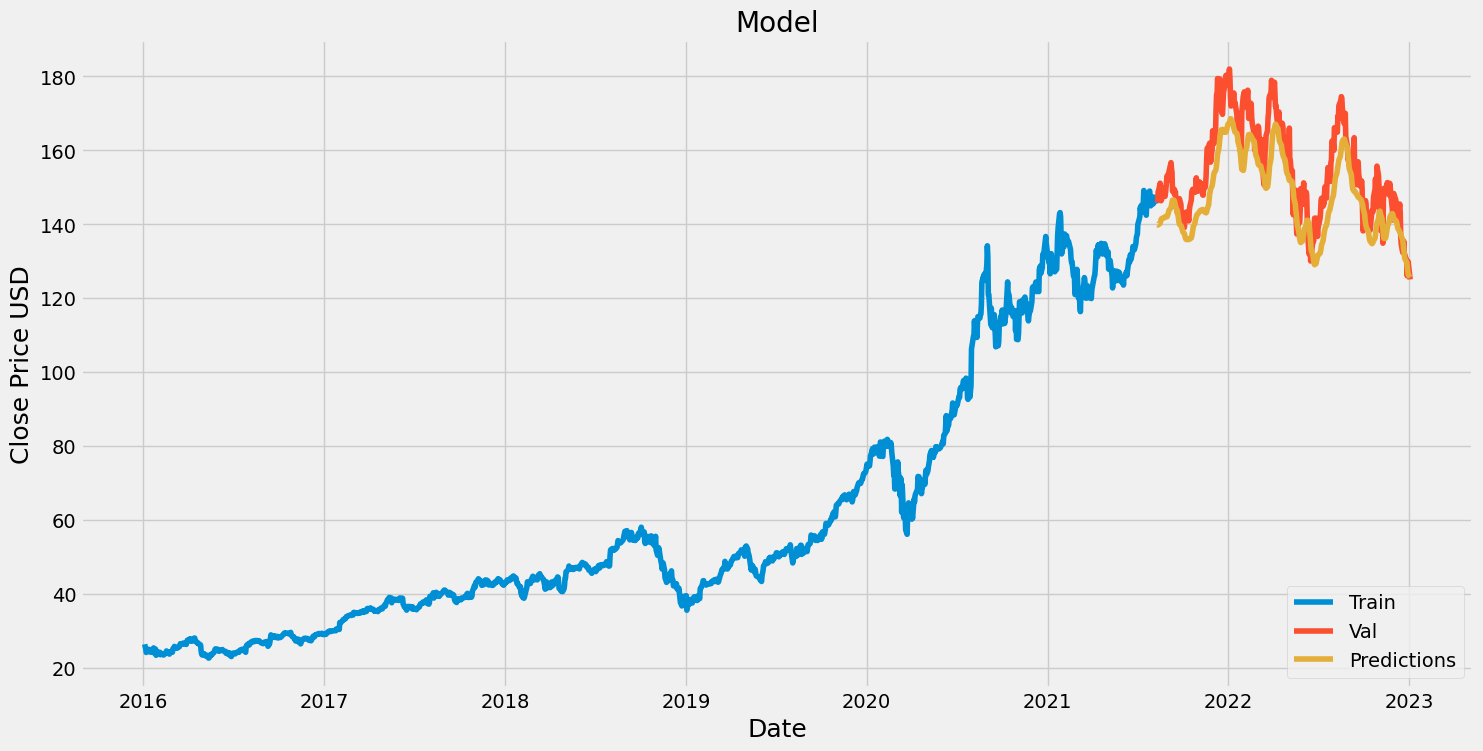

In [27]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [22]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-08-11,145.860001,139.882736
2021-08-12,148.889999,139.805496
2021-08-13,149.100006,139.960281
2021-08-16,151.119995,140.248734
2021-08-17,150.190002,140.759705
...,...,...
2022-12-27,130.029999,129.711563
2022-12-28,126.040001,128.657501
2022-12-29,129.610001,127.401878


In [35]:
y_test.shape

(352, 1)

In [38]:
from sklearn.metrics import mean_absolute_error

# y_train: Gerçek değerler, y_train_pred: Modelin tahminleri
mae_train = mean_absolute_error(y_test, predictions)
print(f"Eğitim Setinde Ortalama Kare Hata (MSE): {mae_train}")

Eğitim Setinde Ortalama Kare Hata (MSE): 7.584533160522461
